<a href="https://colab.research.google.com/github/noambassat/SupremeCourtClassifier/blob/main/5_second_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embedding + first classifier

In [52]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_score, StratifiedKFold,train_test_split,cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_predict, cross_validate
import joblib


In [53]:
data_1 = pd.read_csv("full_final_df.csv")

In [54]:
data_1["outcome_category"].unique()

array([1, 0, 2])

In [55]:
data= data_1[data_1["outcome_category"]!=2] # Drop others

In [56]:
data["binary_outcome"] = data["outcome_category"].apply(lambda x: 1 if x == 1 else 0)

<ipython-input-56-8cca5b4870b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["binary_outcome"] = data["outcome_category"].apply(lambda x: 1 if x == 1 else 0)



## Training

In [57]:

tokenizer = AutoTokenizer.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")
model = AutoModel.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")

In [58]:
# פונקציה שמקבלת טקסט ומחזירה את האימבדינג כוקטור
def get_embeddings(text):
    # המרת הטקסט לפורמט מתאים למודל
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    # חישוב האימבדינג של המודל
    outputs = model(**inputs)
    # חישוב ממוצע הוקטורים עבור כל טקסט
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings[0]

In [59]:
# ביטוי לבדיקה
keyword = "העותק כפוף לשינויי עריכה וניסוח"

# בדיקה אילו שורות מכילות את הביטוי
rows_with_keyword = data["גוף המסמך"].str.contains(keyword, na=False)

# סינון שורות שלא מכילות את הביטוי
filtered_data = data[rows_with_keyword]

# הדפסת השורות שלא מכילות את הביטוי
rows_without_keyword = data[~rows_with_keyword]
print("שורות שלא מכילות את הביטוי:\n")
text = (rows_without_keyword["גוף המסמך"].to_string(index=False))
formatted_text = "\n".join([text[i:i+80] for i in range(0, len(text), 80)])
print(formatted_text)
print("##*******************************************************####")

# הדפסת מספר השורות שנמחקו
num_removed = len(rows_without_keyword)
print(f"\nמספר השורות שנמחקו: {num_removed}")

# שמירת הנתונים המסוננים לקובץ חדש
filtered_data.to_csv("filtered_data.csv", index=False, encoding='utf-8')
print("\nהנתונים המסוננים נשמרו לקובץ: 'filtered_data.csv'")

data = filtered_data

שורות שלא מכילות את הביטוי:

['פסק-דין בתיק ע"פ 4379/02 בבית המשפט העליון בש...
['פסק-דין בתיק ע"פ 7075/03 בב
ית המשפט העליון בש...
['פסק דין בתיק ע"פ 5102/03 בבית המשפט העליון בש...
['504 G
ateway Time-out 504 Gateway Time-out ngi...
['פסק-דין בתיק ע"פ 4654/03 בבית המשפ
ט העליון ע"...
['פסק דין בתיק ע"פ 5102/03 בבית המשפט העליון בש...
['{ "status": 
"Failure", "status_code": 400, "c...
['פסק-דין בתיק ע"פ 10360/03 בבית המשפט העלי
ון ב...
['פסק-דין בתיק ע"פ 10596/03 בבית המשפט העליון ב...
['פסק-דין בתיק ע"פ 10
996/03 בבית המשפט העליון ב...
['פסק-דין בתיק ע"פ 9216/03 בבית המשפט העליון בש...

['{ "status": "Failure", "status_code": 422, "c...
['פסק-דין בתיק ע"פ 3948/03 ב
בית המשפט העליון בש...
['פסק-דין בתיק רע"פ 7861/03 בבית המשפט העליון ר...
['פסק 
דין בתיק ע"פ 2132/04 בבית המשפט העליון בש...
['{ "status": "Failure", "status_co
de": 422, "c...
['פסק-דין בתיק ע"פ 10800/04 בבית המשפט העליון ב...
['פסק-דין בתי
ק ע"פ 2597/04 בבית המשפט העליון בש...
['פסק-דין בתיק ע"פ 7895/04 בבית המשפט העלי

binary_outcome
0    704
1    210
Name: count, dtype: int64


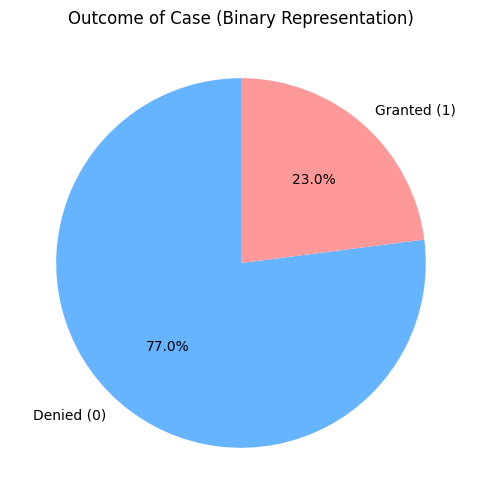

In [60]:
binary_counts = data['binary_outcome'].value_counts()
print(binary_counts)
labels = ['Denied (0)','Granted (1)']

plt.figure(figsize=(6, 6))
plt.pie(binary_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
plt.title('Outcome of Case (Binary Representation)')

plt.show()

In [61]:
# פונקציה לחיתוך הטקסט בהתאם לכללים
def trim_text(text):
    min_length = 450  # אורך מינימלי לשמירה
    last_sen = 1    # מספר תווים להסרה מסוף הטקסט

    # שמירת אורך מקורי לאבחון
    original_length = len(text)

    # הסרת מספר תווים מסוף הטקסט
    text = text[:-last_sen]

    # חיתוך ל-min_length האחרונים אם הטקסט ארוך יותר מהמינימום
    if len(text) > min_length:
        text = text[-min_length:]

    # הדפסת פידבק רק אם הטקסט עבר שינוי
    if len(text) != original_length:
        print(f"Trimmed Text (Original Length: {original_length}, Trimmed Length: {len(text)}):")
        formatted_text = "\n".join([text[i:i+80] for i in range(0, len(text), 80)])
        print(formatted_text)
        print("##*******************************************************####")
    return text


# הסרת שורות עם ערכים חסרים בעמודת הטקסט או בעמודת המטרה
data = data.dropna(subset=["גוף המסמך", "outcome_category"])

# חיתוך הטקסטים בעמודת "גוף המסמך"
data["גוף המסמך"] = data["גוף המסמך"].apply(trim_text)

# # שמירת התוצאה לקובץ
# file_path = 'final_trimmed_data.csv'
# data.to_csv(file_path, index=False, encoding='utf-8')

# print(f"הקובץ נשמר בהצלחה בנתיב: {file_path}")


Streaming output truncated to the last 5000 lines.
Trimmed Text (Original Length: 1671, Trimmed Length: 450):
שומיו של המעשה ילוו אותועוד שנים רבות. בנסיבות אלו, ולנוכח הצורך להגן על שלומם ש
ל קטינים, מצווה היה ביתהמשפט להחמיר עם המערער, ולא זו בלבד שהוא לא נהג כך, אלא ה
סתפק בגזירתו של מאסרמתון על פי כל אמת מידה. לפיכך, דינו של הערעור להדחות, וכך אנ
ו עושים. ניתן היום, י"ז באייר תשס"ו(15.5.2006). ש ו פ טת ש ו פ טת ש ו פ ט_______
__________________העותק כפוף לשינויי עריכה וניסוח. 05095370_O03.doc/שבמרכז מידע,
 טל\' 02-6593666 ; אתר אינטרנט, www.court.gov.il '
##*******************************************************####
Trimmed Text (Original Length: 4339, Trimmed Length: 450):
, אין בידינו להידרש לטענת הסניגור באשר לכך. עםזאת מתבקשים הפרקליטות ושירות המבחן
 ליתן דעתם לשאלה שהעלה הסניגור, קרי, האםמסווגת עבירה כזו בנסיבותיה כאלימות במשפח
ה על משמעותה בהקשרים האמורים, אם לאו. ח. בנתון להערות אלה, אין בידינו כאמורלהיעת
ר לערעורים. ניתן היום, כ"א בתמוז תשס"ו(17.7.06). ה נ ש י א שו פ ט ש ו 

In [ ]:
# עדכון עמודת המטרה ואימבדינג לאחר חיתוך הטקסטים
y = data["binary_outcome"].values
embeddings = np.array([get_embeddings(text) for text in data["גוף המסמך"]])

In [ ]:
# הגדרת undersampler עם יחס של 60-40 לטובת קלאס 0
undersampler = RandomUnderSampler(sampling_strategy=0.6, random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(embeddings, y)

# שמירת אינדקסים מקוריים
resampled_indices = undersampler.sample_indices_
joblib.dump(resampled_indices, 'resampled_indices.pkl')

# ווידוא התאמה: מיפוי y_resampled לעמודת binary_outcome
binary_outcome_resampled = data.iloc[resampled_indices]["binary_outcome"].values
if not np.array_equal(y_resampled, binary_outcome_resampled):
    raise ValueError("Mismatch between y_resampled and resampled binary_outcome values!")

# הגדרת מסווג לוגיסטי עם משקל של 3 עבור קלאס 1
classifier = LogisticRegression(random_state=42, max_iter=1000, class_weight={0: 1, 1: 3})

# התאמת המודל לנתונים המאוזנים
classifier.fit(X_resampled, y_resampled)

# הגדרת מדדים לקרוס ולידציה
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1)
}

# ביצוע Cross Validation
cv_results = cross_validate(classifier, X_resampled, y_resampled, cv=5, scoring=scoring)

# חיזוי תוויות והסתברויות על כל קפל לצורך קונפיושן מטריקס והסתברויות
y_pred = cross_val_predict(classifier, X_resampled, y_resampled, cv=5)
y_prob = cross_val_predict(classifier, X_resampled, y_resampled, cv=5, method='predict_proba')[:, 1]  # הסתברות לקלאס 1
conf_matrix = confusion_matrix(y_resampled, y_pred)

# הדפסת התוצאות
print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
print("Mean Accuracy:", cv_results['test_accuracy'].mean())
print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())

tn, fp, fn, tp = conf_matrix.ravel()

# הדפסת הקונפיושן מטריקס עם תוויות
print("Confusion Matrix with Labels:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

print("\nConfusion Matrix:")
print(f"[[{tn} {fp}]")
print(f" [{fn} {tp}]]")

# שמירת האינדקסים המקוריים של הדגימות המסומפלות
original_indices = data.index[resampled_indices]

# הוספת עמודת הסתברויות
data['predicted_probabilities'] = np.nan
data.loc[original_indices, 'predicted_probabilities'] = y_prob

# שמירת המודל והמשאבים
joblib.dump(classifier, 'second_classifier_model.pkl')
data.to_csv('updated_data_with_probabilities_2.csv', index=False)

print("המודל, התוצאות והנתונים נשמרו בהצלחה.")


In [ ]:
# בדיקה שהעמודה 'predicted_probabilities' קיימת ואינה ריקה
if 'predicted_probabilities' not in data.columns or data['predicted_probabilities'].isna().all():
    raise ValueError("Column 'predicted_probabilities' is missing or contains only NaN values!")

# חישוב ההסתברויות הממוצעת, המינימלית והמקסימלית עבור כל קלאס
for cls in data['binary_outcome'].unique():
    class_data = data[data['binary_outcome'] == cls]['predicted_probabilities']
    avg_prob = class_data.mean()
    min_prob = class_data.min()
    max_prob = class_data.max()

    print(f"Class {cls}:")
    print(f"  Average Probability: {avg_prob:.4f}")
    print(f"  Minimum Probability: {min_prob:.4f}")
    print(f"  Maximum Probability: {max_prob:.4f}\n")


In [ ]:
# בדיקה שהעמודה 'predicted_probabilities' קיימת ואינה ריקה
if 'predicted_probabilities' not in data.columns or data['predicted_probabilities'].isna().all():
    raise ValueError("Column 'predicted_probabilities' is missing or contains only NaN values!")

# יצירת עמודת 'predicted_label' מתוך ההסתברויות (טרשהולד ברירת מחדל: 0.5)
threshold = 0.5  # ניתן לשנות את הטרשהולד לפי הצורך
data['predicted_label'] = (data['predicted_probabilities'] >= threshold).astype(int)

# איתור ה-FN וה-FP
fn_indices = data[(data['binary_outcome'] == 1) & (data['predicted_label'] == 0)].index
fp_indices = data[(data['binary_outcome'] == 0) & (data['predicted_label'] == 1)].index

# חישוב ההסתברויות הממוצעת, המינימלית והמקסימלית עבור FN
if not fn_indices.empty:
    fn_probs = data.loc[fn_indices, 'predicted_probabilities']
    avg_fn_prob = fn_probs.mean()
    min_fn_prob = fn_probs.min()
    max_fn_prob = fn_probs.max()

    print("False Negatives (FN):")
    print(f"  Average Probability: {avg_fn_prob:.4f}")
    print(f"  Minimum Probability: {min_fn_prob:.4f}")
    print(f"  Maximum Probability: {max_fn_prob:.4f}\n")
else:
    print("No False Negatives (FN) found.\n")

# חישוב ההסתברויות הממוצעת, המינימלית והמקסימלית עבור FP
if not fp_indices.empty:
    fp_probs = data.loc[fp_indices, 'predicted_probabilities']
    avg_fp_prob = fp_probs.mean()
    min_fp_prob = fp_probs.min()
    max_fp_prob = fp_probs.max()

    print("False Positives (FP):")
    print(f"  Average Probability: {avg_fp_prob:.4f}")
    print(f"  Minimum Probability: {min_fp_prob:.4f}")
    print(f"  Maximum Probability: {max_fp_prob:.4f}\n")
else:
    print("No False Positives (FP) found.\n")


In [ ]:
# חיזוי תוויות על כל קפל לצורך זיהוי FN
y_pred = cross_val_predict(classifier, X_resampled, y_resampled, cv=5)

# חיזוי הסתברויות
y_prob = cross_val_predict(classifier, X_resampled, y_resampled, cv=5, method='predict_proba')[:, 1]

# איתור האינדקסים של FN - תווית אמיתית היא 1 והתחזית היא 0
fn_indices = np.where((y_resampled == 1) & (y_pred == 0))[0]

# מיפוי האינדקסים של FN לאינדקסים המקוריים של הנתונים
original_fn_indices = resampled_indices[fn_indices]

# קריאת פסקי הדין והערכים בעמודות "Outcome of case", "binary_outcome", "Predicted" ו-"Probability" עבור הדוגמאות שמזוהות כ-FN
false_negative_rows = data.iloc[original_fn_indices]
false_negative_probabilities = y_prob[fn_indices]  # ההסתברויות של המודל עבור FN
false_negative_predicted = y_pred[fn_indices]  # התחזיות של המודל עבור FN

# ווידוא סינכרון מוחלט של האינדקסים
if len(false_negative_rows) != len(false_negative_predicted):
    raise ValueError("Mismatch between FN rows and predicted labels!")

# הדפסת פסקי הדין של FN בצורה מפורמטת עם הערכים המקוריים, התחזית, וההסתברות
print("False Negative Cases (True Label: 1, Predicted Label: 0):")
print("=" * 80)

for i, (index, row, predicted, probability) in enumerate(zip(original_fn_indices, false_negative_rows.iterrows(), false_negative_predicted, false_negative_probabilities), 1):
    _, row_data = row
    print(f"\nCase {i}:")
    print("-" * 80)
    print("Index in Original Data:")
    print(index)
    print("\nOriginal Outcome of Case:")
    print(row_data["Outcome of case"])
    print("\nBinary Outcome (True Label):")
    print(row_data["binary_outcome"])
    print("\nPredicted Label:")
    print(predicted)
    print("\nPredicted Probability:")
    print(f"{probability:.4f}")
    print("\nDocument Body:")
    formatted_text = "\n".join(row_data["גוף המסמך"][j:j + 80] for j in range(0, len(row_data["גוף המסמך"]), 80))
    print(formatted_text)
    print("-" * 80)

print("=" * 80)


In [ ]:
# סינון דוגמאות FN בעלות הסתברויות גבוהות
high_prob_threshold = 0.4  # הסתברויות מעל 0.4
high_prob_fn_indices = np.where((y_resampled == 1) & (y_pred == 0) & (y_prob >= high_prob_threshold))[0]

# מיפוי האינדקסים של דוגמאות FN בעלות הסתברויות גבוהות
high_prob_original_fn_indices = resampled_indices[high_prob_fn_indices]
high_prob_fn_rows = data.iloc[high_prob_original_fn_indices]
high_prob_fn_probabilities = y_prob[high_prob_fn_indices]

# הדפסת המקרים
print("High-Probability False Negative Cases (True Label: 1, Predicted Label: 0):")
print("=" * 80)

for i, (index, row, probability) in enumerate(zip(high_prob_original_fn_indices, high_prob_fn_rows.iterrows(), high_prob_fn_probabilities), 1):
    _, row_data = row
    print(f"\nCase {i}:")
    print("-" * 80)
    print("Index in Original Data:")
    print(index)
    print("\nOriginal Outcome of Case:")
    print(row_data["Outcome of case"])
    print("\nBinary Outcome (True Label):")
    print(row_data["binary_outcome"])
    print("\nPredicted Probability:")
    print(f"{probability:.4f}")
    print("\nDocument Body:")
    formatted_text = "\n".join(row_data["גוף המסמך"][j:j + 80] for j in range(0, len(row_data["גוף המסמך"]), 80))
    print(formatted_text)
    print("-" * 80)

print("=" * 80)


In [ ]:
# איתור האינדקסים של FP - תווית אמיתית היא 0 והתחזית היא 1
fp_indices = np.where((y_resampled == 0) & (y_pred == 1))[0]

# סינון דוגמאות FP בעלות הסתברויות גבוהות
high_prob_threshold_fp = 0.7  # הסתברויות מעל 0.7
high_prob_fp_indices = np.where((y_resampled == 0) & (y_pred == 1) & (y_prob >= high_prob_threshold_fp))[0]

# מיפוי האינדקסים של דוגמאות FP בעלות הסתברויות גבוהות
high_prob_original_fp_indices = resampled_indices[high_prob_fp_indices]
high_prob_fp_rows = data.iloc[high_prob_original_fp_indices]
high_prob_fp_probabilities = y_prob[high_prob_fp_indices]

# הדפסת המקרים
print("High-Probability False Positive Cases (True Label: 0, Predicted Label: 1):")
print("=" * 80)

for i, (index, row, probability) in enumerate(zip(high_prob_original_fp_indices, high_prob_fp_rows.iterrows(), high_prob_fp_probabilities), 1):
    _, row_data = row
    print(f"\nCase {i}:")
    print("-" * 80)
    print("Index in Original Data:")
    print(index)
    print("\nOriginal Outcome of Case:")
    print(row_data["Outcome of case"])
    print("\nBinary Outcome (True Label):")
    print(row_data["binary_outcome"])
    print("\nPredicted Probability:")
    print(f"{probability:.4f}")
    print("\nDocument Body:")
    formatted_text = "\n".join(row_data["גוף המסמך"][j:j + 80] for j in range(0, len(row_data["גוף המסמך"]), 80))
    print(formatted_text)
    print("-" * 80)

print("=" * 80)
